# Imperfect conductor - Discussion

In [1]:
# Temporary 'hack' for working directory not coinciding with file directory
import os
os.chdir('/home/fenics/shared/examples/imperfect_conductor')

#%load_ext autoreload
#%autoreload 2

In [2]:
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm
cm = matplotlib.cm.get_cmap('viridis')

import fenics as fen
import mshr
#from imperfect_conductor import ImperfectConductor

from context import src
from src.vector_space import VectorSpaceL2
from src.minimal_rational_interpolation import MinimalRationalInterpolation
import src.helpers as helpers

In [13]:
# -*- coding: utf-8 -*-

import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import pickle

import fenics as fen

from src.snapshot_matrix import SnapshotMatrix

class TimeHarmonicMaxwellProblem(object):
    """
    Finite element solver for solutions to the time harmonic
    Maxwell's equations formulated in the vector potential A
    
        \/ x ((1 / mu) \/ x A) - eps * omega^2 * A = j
    with boundary conditions
        A = A_D                     (Dirichlet boundaries, B_D)
        ((1 / mu) \/ x A) x n = g_N   (Neumann boundaries, B_N)
 
    Members
    -------
    V : dolfin.functions.functionspace.FunctionSpace
        Real FE space.
    A : list[dolfin.functions.function.TrialFunction]
        Trial function.
    v : dolfin.functions.function.TestFunction
        Test function.
    K : dolfin.cpp.la.Matrix
        Stiffness matrix.  
    M : dolfin.cpp.la.Matrix
        Mass matrix.
    L : dolfin.cpp.la.Vector
        Source term.
    N : dolfin.cpp.la.Vector
        Neumann boundary integral term.
    mu : dolfin.functions.expression.Expression
        Permeability.
    eps : dolfin.functions.expression.Expression
        Permittivity.
    j : dolfin.functions.expression.Expression
        Current density
    B_D : dolfin.cpp.mesh.SubDomain
        SubDomain object locating the Dirichlet boundary.
    B_N : dolfin.cpp.mesh.SubDomain
        SubDomain object locating the Neumann boundary.
    A_0 : dolfin.functions.expression.Expression
        Dirichlet boundary condition.
    g_N : dolfin.functions.expression.Expression
        Neumann boundary condition.
    A_sol : dolfin.functions.function.Function
        Solution to the variational problem.
    bc : dolfin.fem.bcs.DirichletBC
        Dirichlet boundary condition object.
    omega : list[float] or float
        Frequency for which the variational problem is solved.

    Methods
    -------
    setup() : None -> None
        Assemble the stiffness, mass, and source terms.
    solve(omega) : float -> None
        Computes the solution to the weak variational problem at omega.
    tosparse(A) : dolfin.cpp.la.Matrix -> scipy.sparse.csr_matrix
        Convert dolfin matrix to scipy sparse matrix in the CSR format.
    ...
    
    References
    ----------
    [1] FEniCS Project 2021: https://fenicsproject.org/
    [2] Pradovera D. and Nobile F. Frequency-domain non-intrusive greedy
        Model Order Reduction based on minimal rational approximation
    
    Usage
    -----
    Square waveguide with perfectly conducting walls and an inlet.
    >>> V = fen.FunctionSpace(fen.UnitSquareMesh(10, 10), 'P', 1)
    >>> mu = eps = fen.Constant(1.0)
    >>> j = fen.Constant(0.0)
    >>>
    >>> class B_D(fen.SubDomain):
    >>>     def inside(self, x, on_boundary):
    >>>         return not fen.near(x[0], 0.0)
    >>> class B_N(fen.SubDomain):
    >>>    def inside(self, x, on_boundary):
    >>>         return fen.near(x[0], 0.0)
    >>> 
    >>> A_D = fen.Constant(0.0)
    >>> g_N = fen.Constant(1.0)
    >>>
    >>> MP = MaxwellProblem(V, mu, eps, j, B_D(), B_N(), A_D, g_N)
    >>> MP.setup()
    >>> MP.solve(1)
    >>> A_sol = MP.get_solution()
    """

    def __init__(self, V, mu, eps, j, B_D, B_N, B_I, A_D, g_N, imp):
        self.V = V
        self.K = None
        self.M = None
        self.L = None
        self.N = None
        self.I = None
        self.mu = mu
        self.eps = eps
        self.j = j
        self.B_D = B_D
        self.B_N = B_N
        self.B_I = B_I
        self.imp = imp
        self.A_D = A_D
        self.g_N = g_N
        self.A_sol = None
        self.bc = None
        self.omega = None

    def setup(self):
        """Assemble the stiffness and mass matrices with boundary conditions"""
        # Boundary function to identify Dirichlet and Neumann boundaries
        mesh = self.V.mesh()
        boundary_type = fen.MeshFunction('size_t', mesh, mesh.topology().dim() - 1)
        boundary_type.set_all(0)
        self.B_D.mark(boundary_type, 1)
        self.B_N.mark(boundary_type, 2)
        self.B_I.mark(boundary_type, 3)

        A = fen.TrialFunction(self.V)
        v = fen.TestFunction(self.V)
        
        # Dirichlet boundary conditions
        self.bc = fen.DirichletBC(self.V, self.A_D, boundary_type, 1)

        # Neumann boundary conditions
        ds = fen.Measure('ds', subdomain_data=boundary_type)
        self.N = fen.assemble(fen.dot(self.g_N, v) * ds(2))

        # Impedance boundary condition
        ds = fen.Measure('ds', subdomain_data=boundary_type)
        n = fen.FacetNormal(mesh)
        if self.V.tabulate_dof_coordinates().shape[1] == 2:
            self.I = fen.assemble(self.imp * fen.dot(A, v) * ds(3))
        else:
            self.I = fen.assemble(self.imp * fen.dot(fen.cross(fen.cross(n, A), n), v) * ds(3))

        # Assembly of stiffness, mass, and forcing term
        self.K = fen.assemble(1/self.mu * fen.dot(fen.curl(A), fen.curl(v)) * fen.dx)
        self.bc.apply(self.K)

        self.M = fen.assemble(self.eps * fen.dot(A, v) * fen.dx)
        self.bc.zero(self.M)

        self.L = fen.assemble(fen.dot(self.j, v) * fen.dx)
        self.bc.apply(self.L)

    def _solve(self, omega, accumulate=False):
        """Solve the variational problem defined with .setup()"""
        if not accumulate:
            self.A_sol = []
            self.omega = []
        if isinstance(omega, (float, int)):
            omega = [omega]
        self.omega.extend(omega)
        for omg in omega:
            LHS = self.K - omg**2 * self.M
            RHS = self.L + self.N
            A = fen.Function(self.V)
            fen.solve(LHS, A.vector(), RHS)
            self.A_sol.append(A)
    
    def solve(self, omega, accumulate=False):
        """Solve the variational problem defined with .setup()"""
        if not accumulate:
            self.A_sol = []
            self.omega = []
        if isinstance(omega, (float, int)):
            omega = [omega]
        self.omega.extend(omega)
        for omg in omega:
            LHS_re = self.tosparse(self.K) - omg**2 * self.tosparse(self.M)
            LHS_im = - omg * self.tosparse(self.I)
            RHS_re = self.L.get_local() + self.N.get_local()
            RHS_im = np.zeros_like(RHS_re)
            LHS = scipy.sparse.vstack([scipy.sparse.hstack([LHS_re, -LHS_im], format='csr'),
                                       scipy.sparse.hstack([LHS_im, -LHS_re], format='csr')], format='csr')
            RHS = np.r_[RHS_re, RHS_im]
            A = scipy.sparse.linalg.spsolve(LHS, RHS)
            self.A_sol.append(A)

    def get_numerical_eigenfrequencies(self, a=-np.inf, b=np.inf, k=10, v0=None, return_eigvecs=False):
        """Solve an eigenvalue problem K*v = omega^2*M*v"""
        if a == -np.inf or b == np.inf:
            sigma = None
        else:
            sigma = (a + b) / 2

        # Only use non-zero (not on boundary) components in M and K
        inner_indices = self.get_inner_indices()
        if v0 is not None:
            v0 = v0[inner_indices]
        K = self.get_K(tosparse=True)[inner_indices, :][:, inner_indices]
        M = self.get_M(tosparse=True)[inner_indices, :][:, inner_indices]
        eigvals, eigvecs = scipy.sparse.linalg.eigsh(A=K, k=k, M=M, sigma=sigma, v0=v0)

        # Only return eigenfrequencies (square root of eigenvalues) in [a, b]
        eigvals = np.sqrt(eigvals)
        eigvals_in_ab = [e1 for e1 in eigvals if a <= e1 and e1 <= b]

        if len(eigvals_in_ab) == k:
            print(f'WARNING: Found exactly {k} eigenvalues within [{a}, {b}].')
            print('Increase parameter "k" to ensure all eigenvalues are found.')

        if return_eigvecs:
            eigvecs_in_ab = [e2 for e1, e2 in zip(eigvals, eigvecs.T) if a <= e1 and e1 <= b]
            return eigvals_in_ab, eigvecs_in_ab
        return eigvals_in_ab

    @staticmethod
    def tosparse(A):
        """Convert dolfin matrix to a sparse SciPy matrix in CSR format"""
        A_mat = fen.as_backend_type(A).mat()
        A_shape = (A.size(0), A.size(1))
        A_sparse = scipy.sparse.csr_matrix(A_mat.getValuesCSR()[::-1], shape=A_shape)
        return A_sparse

    def get_V(self):
        """Return the finite element function space V"""
        return self.V

    def get_K(self, tosparse=True): 
        """Return the stiffness matrix K"""
        if tosparse:
            return self.tosparse(self.K)
        return self.K

    def get_M(self, tosparse=True):
        """Return the mass matrix M"""
        if tosparse:
            return self.tosparse(self.M)
        return self.M

    def get_L(self, tonumpy=True):
        """Return the source integral term L"""
        if tonumpy:
            return self.L.get_local()
        return self.L

    def get_N(self, tonumpy=True):
        """Return the Neumann boundary integral term N"""
        if tonumpy:
            return self.N.get_local()
        return self.N

    def get_solution(self, tonumpy=True, trace=None):
        """Return the solution obtained with .solve()"""
        if trace is not None:
            coords = self.V.tabulate_dof_coordinates()
            is_on_trace = lambda x: trace.inside(x, 'on_boundary')
            on_trace = np.apply_along_axis(is_on_trace, 1, coords)
            if isinstance(self.A_sol, np.ndarray):
                return self.A_sol[:, on_trace]
            return np.array([a.vector().get_local()[on_trace] for a in self.A_sol])
        if tonumpy:
            if isinstance(self.A_sol, np.ndarray):
                return self.A_sol
            return np.array([a.vector().get_local() for a in self.A_sol])
        return self.A_sol

    def save_solution(self, dirname, trace=None):
        SM = SnapshotMatrix(self.get_solution(tonumpy=True, trace=trace), self.omega)
        with open(dirname, 'wb') as file:
            pickle.dump(SM, file)

    def load_solution(self, dirname):
        with open(dirname, 'rb') as file:
            SM = pickle.load(file)
        self.A_sol = SM.get_snapshots()
        self.omega = SM.get_frequencies()

    def get_frequency(self):
        """Return the frequencies corresponding to the solutions"""
        return np.array(self.omega)

    def get_boundary_indices_and_values(self):
        """Return list of indices and values of boundary points"""
        boundary_dict = self.bc.get_boundary_values()
        return list(boundary_dict.keys()), list(boundary_dict.values())

    def get_inner_indices(self):
        """Return list of indices that do not correspond to boundary points"""
        boundary_indices, _ = self.get_boundary_indices_and_values()
        all_indices = self.V.dofmap().dofs()
        return np.delete(all_indices, boundary_indices)
    
    def insert_boundary_values(self, A_vec):
        """Insert boundary values into a vector with omitted boundary points"""
        boundary_indices, boundary_values = self.get_boundary_indices_and_values()
        inner_indices = self.get_inner_indices()
        A_vec_inserted = np.empty(self.V.dim())
        A_vec_inserted[inner_indices] = A_vec
        A_vec_inserted[boundary_indices] = boundary_values
        return A_vec_inserted


In [14]:
class ImperfectConductor(TimeHarmonicMaxwellProblem):
    def __init__(self, Lx, Ly, Nx, Ny, g_N, imp):
        self.Lx = Lx
        self.Ly = Ly
        self.Nx = Nx
        self.Ny = Ny
        mesh = fen.RectangleMesh(fen.Point(0.0, 0.0), fen.Point(self.Lx, self.Ly), Nx, Ny, 'crossed')
        V = fen.FunctionSpace(mesh, 'P', 1)

        mu = fen.Expression('1.0', degree=2)
        eps = fen.Expression('1.0', degree=2)
        j = fen.Expression('0.0', degree=2)

        class B_N(fen.SubDomain):
            def inside(self_, x, on_boundary):
                return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<self.Ly
            
        class B_I(fen.SubDomain):
            def inside(self_, x, on_boundary):
                return on_boundary and fen.near(x[0], self.Lx) and x[1]>0.0 and x[1]<self.Ly

        class B_D(fen.SubDomain):
            def inside(self, x, on_boundary):
                return on_boundary and not (B_N().inside(x, 'on_boundary') or B_I().inside(x, 'on_boundary'))

        A_D = fen.Expression('0.0', degree=2)

        TimeHarmonicMaxwellProblem.__init__(self, V, mu, eps, j, B_D(), B_N(), B_I(), A_D, g_N, imp)

    def plot_solution(self, **kwargs):
        A_sol = self.get_solution(tonumpy=False)
        for i, A in enumerate(A_sol):
            plt.figure()
            plt.title('Solution to system at frequency \u03C9 = {:.3f} rad/s'.format(self.omega[i]))
            fig = fen.plot(A, **kwargs)
            plt.colorbar(fig, orientation='horizontal')
            plt.show()

    def plot_solution_trace(self, trace, **kwargs):
        A_sol = self.get_solution(tonumpy=False)
        for i, A in enumerate(A_sol):
            plt.figure()
            plt.title('Solution on trace at frequency \u03C9 = {:.3f} rad/s'.format(self.omega[i]))
            all_coords = self.V.tabulate_dof_coordinates()
            trace_coords = np.array([x for x in all_coords if trace.inside(x, 'on_boundary')])
            A_trace = [A(x) for x in trace_coords]
            plt.plot(trace_coords[:, 1], A_trace, **kwargs)
            plt.show()

    def plot_external_solution(self, A_vec, contains_boundary_values=False, omega=None, **kwargs):
        plt.figure()
        if omega is not None:
            plt.title('Solution to system at frequency \u03C9 = {:.3f} rad/s'.format(omega))
        A_func = fen.Function(self.V)
        if not contains_boundary_values:
            A_vec = self.insert_boundary_values(A_vec)
        A_func.vector()[:] = A_vec
        fig = fen.plot(A_func, **kwargs)
        plt.colorbar(fig, orientation='horizontal')
        plt.show()

    def plot_g_N(self, **kwargs):
        plt.figure()
        all_coords = self.V.tabulate_dof_coordinates()
        inlet_coords = np.array([x for x in all_coords if self.B_N.inside(x, 'on_boundary')])
        g_N_coords = [self.g_N(x) for x in inlet_coords]
        plt.plot(inlet_coords[:, 1], g_N_coords, **kwargs)
        plt.ylabel('g_N')
        plt.xlim(0.0, self.Ly)
        plt.show()

    def get_analytical_eigenfrequencies(self, a, b):
        freqs = lambda n, m: np.pi*pow(((n+0.5)/self.Lx)**2 + (m/self.Ly)**2, 0.5)
        n_max = np.ceil(b * self.Lx / np.pi - 0.5).astype('int')
        m_max = np.ceil(b * self.Ly / np.pi).astype('int')
        eigs = np.unique(np.frompyfunc(freqs, 2, 1).outer(range(n_max+1), range(1, m_max+1)))
        return [e for e in eigs if a <= e and e <= b]


## Imperfect conductor

In [5]:
RC.B_I.inside([5.0, 0.5],  'on_boundary')

NameError: name 'RC' is not defined

In [15]:
Lx, Ly = 5.0, 1.0
Nx, Ny = 101, 21
m = 1
g_N = fen.Expression('sin(x[1]*m*pi/Ly)', degree=2, Ly=Ly, m=m)
imp = fen.Expression('0.1', degree=2)
RC = ImperfectConductor(Lx=Lx, Ly=Ly, Nx=Nx, Ny=Ny, g_N=g_N, imp=imp)
RC.setup()
#RC.plot_g_N()

class inlet(fen.SubDomain):
    def inside(self, x, on_boundary):
        return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<Ly

Calling FFC just-in-time (JIT) compiler, this may take some time.


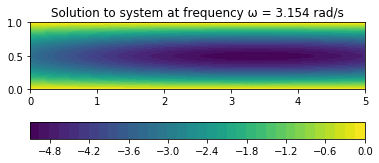

In [51]:
omega = 3.154
RC.solve(omega)
sol = RC.get_solution(tonumpy=False)[0]
RC.plot_external_solution(sol[:4365], contains_boundary_values=True, omega=omega)

### Full cavity

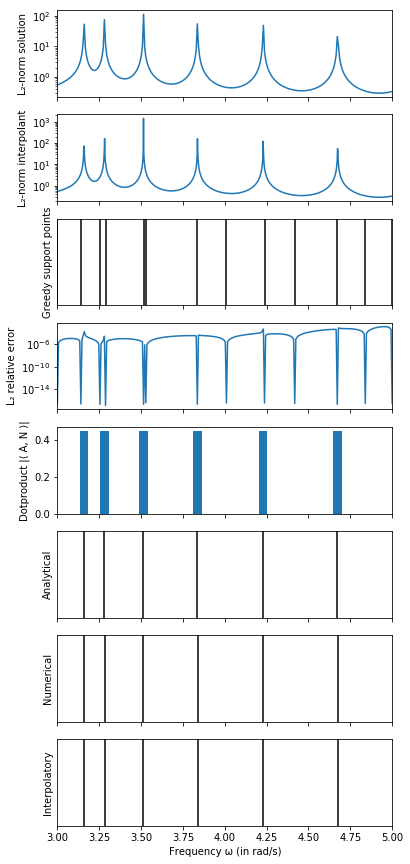

In [4]:
fig, ax = plt.subplots(8, 1, figsize=(6, 15), sharex=True)

a = 3
b = 5
omegas = np.linspace(a, b, 300)
RC.solve(omegas)
VS = VectorSpaceL2(RC)
MRI = MinimalRationalInterpolation(VS)
snapshots = RC.get_solution(tonumpy=True, trace=VS.get_trace())
omegas = RC.get_frequency()
MRI.compute_surrogate(snapshots, omegas, greedy=True, tol=1e-1)

ax[0].set_ylabel('L\u2082-norm solution')
helpers.plot_solution_norms(ax[0], RC, VS)

ax[1].set_ylabel('L\u2082-norm interpolant')
helpers.plot_surrogate_norms(ax[1], MRI, a, b)

ax[2].set_ylabel('Greedy support points')
helpers.plot_lines(ax[2], MRI.A_ring.get_nodes())

ax[3].set_ylabel('L\u2082 relative error')
helpers.plot_surrogate_error_norms(ax[3], RC, MRI, VS)

eigfreqs, eigvecs = RC.get_numerical_eigenfrequencies(a, b, return_eigvecs=True)

ax[4].set_ylabel('Dotproduct |\u27E8 A, N \u27E9|')
ax[4].bar(eigfreqs, np.abs([np.inner(RC.insert_boundary_values(eigvec), RC.get_N()) for eigvec in eigvecs]), width=0.05)

ax[5].set_ylabel('Analytical')
helpers.plot_lines(ax[5], RC.get_analytical_eigenfrequencies(a, b))

ax[6].set_ylabel('Numerical')
helpers.plot_lines(ax[6], eigfreqs)

ax[7].set_ylabel('Interpolatory')
helpers.plot_lines(ax[7], MRI.get_interpolatory_eigenfrequencies(only_real=True))

ax[-1].set_xlabel('Frequency \u03C9 (in rad/s)')
ax[-1].set_xlim(a, b)
plt.show()

In [ ]:
class ImperfectConductor(TimeHarmonicMaxwellProblem):
    def __init__(self, Lx, Ly, Nx, Ny, g_N, imp):
        self.Lx = Lx
        self.Ly = Ly
        self.Lz = 1
        self.Nx = Nx
        self.Ny = Ny
        self.Nz = 11
        #mesh = fen.RectangleMesh(fen.Point(0.0, 0.0), fen.Point(self.Lx, self.Ly), Nx, Ny, 'crossed')
        mesh = fen.BoxMesh(fen.Point(0.0, 0.0, 0.0), fen.Point(self.Lx, self.Ly, self.Lz), self.Nx, self.Ny, self.Nz)
        V = fen.FunctionSpace(mesh, 'N1curl', 1)

        mu = fen.Expression('1.0', degree=2)
        eps = fen.Expression('1.0', degree=2)
        j = fen.Expression(('0.0', '0.0', '0.0'), degree=2)

        class B_N(fen.SubDomain):
            def inside(self_, x, on_boundary):
                return on_boundary and fen.near(x[0], 0.0) and x[1]>0.0 and x[1]<self.Ly and x[2]>0.0 and x[2]<self.Lz
            
        class B_I(fen.SubDomain):
            def inside(self_, x, on_boundary):
                return on_boundary and fen.near(x[0], self.Lx) and x[1]>0.0 and x[1]<self.Ly and x[2]>0.0 and x[2]<self.Lz

        class B_D(fen.SubDomain):
            def inside(self, x, on_boundary):
                return on_boundary and not (B_N().inside(x, 'on_boundary') or B_I().inside(x, 'on_boundary'))

        A_D = fen.Expression(('0.0', '0.0', '0.0'), degree=2)

        TimeHarmonicMaxwellProblem.__init__(self, V, mu, eps, j, B_D(), B_N(), B_I(), A_D, g_N, imp)

    def plot_solution(self, **kwargs):
        A_sol = self.get_solution(tonumpy=False)
        for i, A in enumerate(A_sol):
            plt.figure()
            plt.title('Solution to system at frequency \u03C9 = {:.3f} rad/s'.format(self.omega[i]))
            fig = fen.plot(A, **kwargs)
            plt.colorbar(fig, orientation='horizontal')
            plt.show()

    def plot_solution_trace(self, trace, **kwargs):
        A_sol = self.get_solution(tonumpy=False)
        for i, A in enumerate(A_sol):
            plt.figure()
            plt.title('Solution on trace at frequency \u03C9 = {:.3f} rad/s'.format(self.omega[i]))
            all_coords = self.V.tabulate_dof_coordinates()
            trace_coords = np.array([x for x in all_coords if trace.inside(x, 'on_boundary')])
            A_trace = [A(x) for x in trace_coords]
            plt.plot(trace_coords[:, 1], A_trace, **kwargs)
            plt.show()

    def plot_external_solution(self, A_vec, contains_boundary_values=False, omega=None, **kwargs):
        plt.figure()
        if omega is not None:
            plt.title('Solution to system at frequency \u03C9 = {:.3f} rad/s'.format(omega))
        A_func = fen.Function(self.V)
        if not contains_boundary_values:
            A_vec = self.insert_boundary_values(A_vec)
        A_func.vector()[:] = A_vec
        fig = fen.plot(A_func, **kwargs)
        plt.colorbar(fig, orientation='horizontal')
        plt.show()

    def plot_g_N(self, **kwargs):
        plt.figure()
        all_coords = self.V.tabulate_dof_coordinates()
        inlet_coords = np.array([x for x in all_coords if self.B_N.inside(x, 'on_boundary')])
        g_N_coords = [self.g_N(x) for x in inlet_coords]
        plt.plot(inlet_coords[:, 1], g_N_coords, **kwargs)
        plt.ylabel('g_N')
        plt.xlim(0.0, self.Ly)
        plt.show()

    def get_analytical_eigenfrequencies(self, a, b):
        freqs = lambda n, m: np.pi*pow(((n+0.5)/self.Lx)**2 + (m/self.Ly)**2, 0.5)
        n_max = np.ceil(b * self.Lx / np.pi - 0.5).astype('int')
        m_max = np.ceil(b * self.Ly / np.pi).astype('int')
        eigs = np.unique(np.frompyfunc(freqs, 2, 1).outer(range(n_max+1), range(1, m_max+1)))
        return [e for e in eigs if a <= e and e <= b]
